In [5]:
! pip install -q transformers


In [43]:
import torch

from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
# Load Image
from PIL import Image

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

clip_model = model.clip

CLIPSegModel(
  (text_model): CLIPSegTextTransformer(
    (embeddings): CLIPSegTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPSegEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPSegEncoderLayer(
          (self_attn): CLIPSegAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPSegMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNo

In [45]:
image = Image.open("../dataset/image_0.jpeg") 

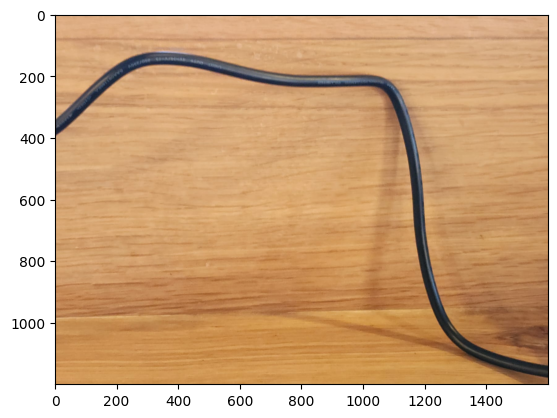

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(image)


In [13]:
prompts = ["a cable"]
inputs = processor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt")
# predict
with torch.no_grad():
  outputs = model(**inputs)
preds = outputs.logits.unsqueeze(1)

In [46]:
# Get text embeddings
text_embeds = clip_model.get_text_features(input_ids=inputs["input_ids"])

# Get image embeddings
image_embeds = clip_model.get_image_features(pixel_values=inputs["pixel_values"])

print("Text embeddings shape:", text_embeds.shape)
print("Image embeddings shape:", image_embeds.shape)

Text embeddings shape: torch.Size([1, 512])
Image embeddings shape: torch.Size([1, 512])


In [15]:
import torch.nn as nn
# resize the outputs
preds = nn.functional.interpolate(
    outputs.logits.unsqueeze(1),
    size=(image.size[1], image.size[0]),
    mode="bilinear"
)

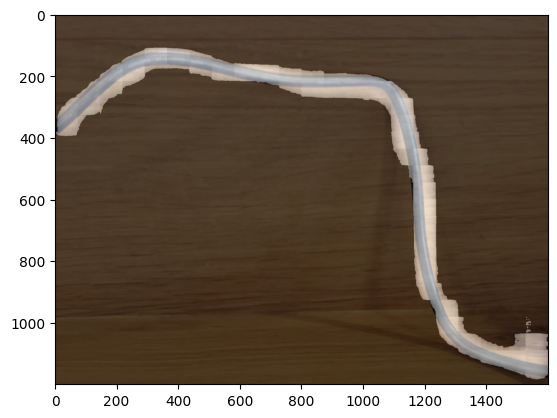

In [37]:
sig_pred = torch.sigmoid(preds[0][0]).cpu().numpy()
sig_pred[sig_pred <= 0.5] = 0
plt.imshow(sig_pred, cmap="gray")
plt.imshow(image, alpha=0.6)
plt.imshow(sig_pred, cmap="gray", alpha=0.4)
plt.show()

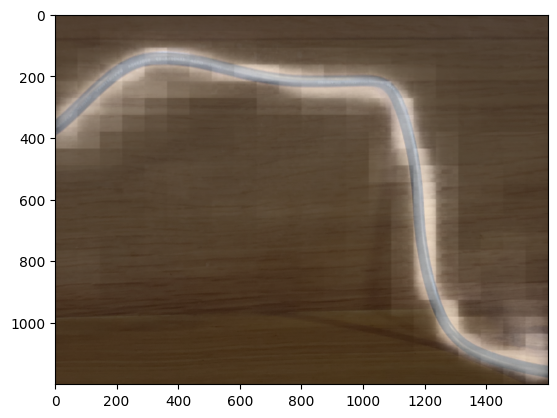

In [20]:

plt.imshow(torch.sigmoid(preds[0][0]).cpu().numpy(), cmap="gray")
plt.imshow(image, alpha=0.6)
plt.imshow(torch.sigmoid(preds[0][0]).cpu().numpy(), cmap="gray", alpha=0.4)
plt.show()

In [21]:
! pip install scikit-image

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 54.7 MB/s eta 0:00:00m eta 0:00:010:0101
  Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.8/315.8 KB 107.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 KB 105.2 MB/s eta 0:00:00


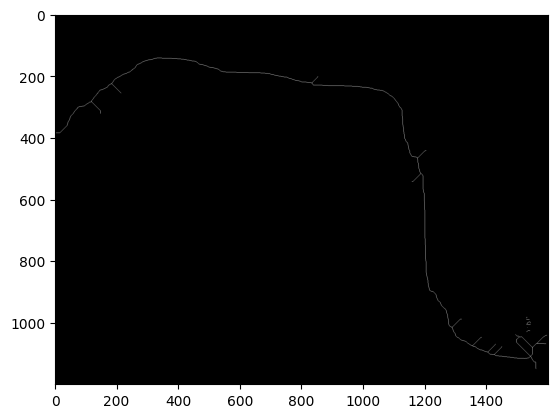

In [41]:
from skimage.morphology import skeletonize
import numpy as np

# Convert the predictions to a binary mask
binary_mask = torch.sigmoid(preds[0][0]).cpu().numpy() > 0.5

# Skeletonize the binary mask
skeleton = skeletonize(binary_mask)

# Plot the skeletonized mask
plt.imshow(skeleton, cmap="gray")
plt.show()